In [1]:
import functools
import numpy as np
import jax 
import optax
import haiku as hk
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context='talk', font_scale=1.0)

import utils

2022-02-15 19:44:37.851930: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/yardenas/.mujoco/mujoco210/bin


In [2]:
%matplotlib inline

## Generate Data

In [3]:
def load_dataset(x_range, b0, w0, n=150, n_tst=150):
    np.random.seed(43)

    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)

    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    # y = (w0 * x * (1 + np.sin(x)) + b0) + eps
    y = (w0 * x * (1 + np.sin(x)) + b0) + eps
    y = (y-y.mean()) / y.std()
    xm, xs = x.mean(), x.std()
    x = x[..., None]
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    x_tst = x_tst[..., None]
    
    def normalize(x):
        return (x - xm) / xs
    return (y.astype(np.float32), normalize(x).astype(np.float32), 
            normalize(x_tst).astype(np.float32))

def dataset(x, y, batch_size):
    ids = np.arange(len(x))
    while True:
        ids = np.random.choice(ids, batch_size, False)
        yield x[ids].astype(np.float32), y[ids].astype(np.float32)
        
w0 = 0.125
b0 = 0.
x_range = [-20, 60]
batch_size = 32
y, x, x_tst = load_dataset(x_range, b0, w0)
data = iter(dataset(x, y, batch_size))

## Plotting

In [4]:
def plot(x, y, x_tst, yhats):
    plt.figure(figsize=[15, 4.0], dpi= 100)  # inches
    plt.plot(x, y, 'b.', label='observed')

    avgm = np.zeros_like(x_tst[..., 0])
    for i, yhat in enumerate(yhats):
        m = np.squeeze(yhat.mean())
        s = np.squeeze(yhat.stddev())
        if i < 15:
            plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
            plt.plot(x_tst, m + 3 * s, 'g', linewidth=0.5, label='ensemble means + 3 ensemble stdev' if i == 0 else None)
            plt.plot(x_tst, m - 3 * s, 'g', linewidth=0.5, label='ensemble means - 3 ensemble stdev' if i == 0 else None)
        avgm += m
    plt.plot(x_tst, avgm / len(yhats), 'r', label='overall mean', linewidth=4)
    ax = plt.gca()
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(0.95, 0.5))
    plt.tight_layout()

## Prior Predictive Check

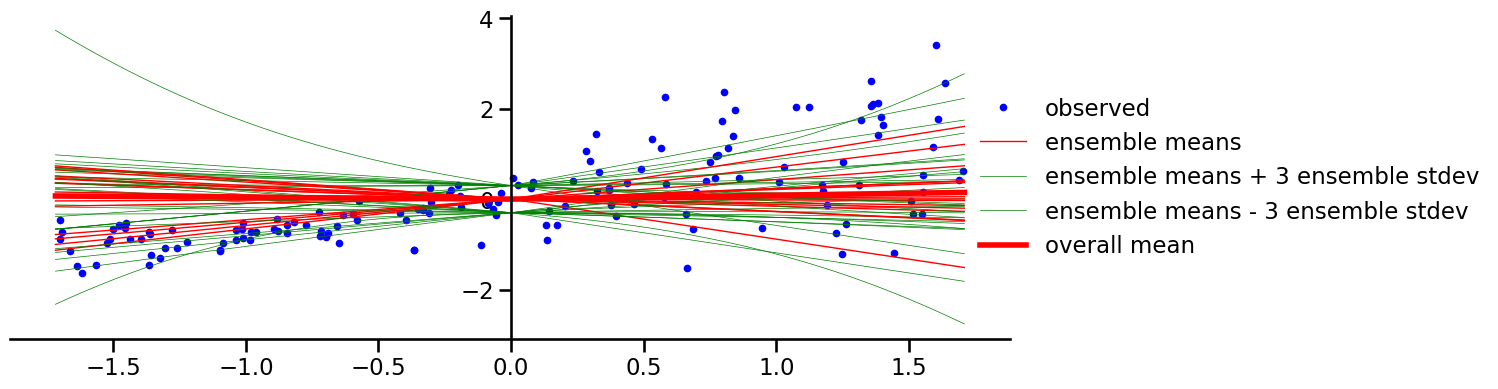

In [5]:
from f_povi import FunctionalParticleOptimization
net_fn = functools.partial(utils.net, n_layers=2, n_hidden=50)
model = FunctionalParticleOptimization(x[:batch_size], 20, net_fn)
plot(x, y, x_tst, model.predict(x_tst))

## Train with Bayes-by-Backprop

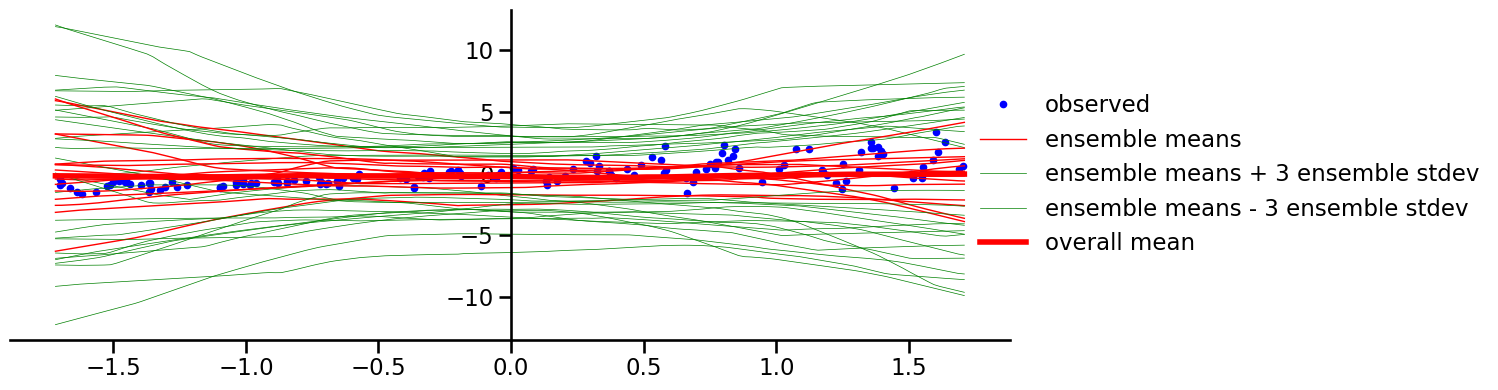

In [8]:
from bayes_by_backprop import BayesByBackprop
model = BayesByBackprop(x[:batch_size], 20, functools.partial(net_fn, sd_scale=0.01, sd_max=2.0))
opt = optax.flatten(optax.adam(0.005))
keys = hk.PRNGSequence(jax.random.PRNGKey(42))

@jax.jit
def update(x, y, params, key, opt_state):
    grads = model.update_step(params, key, x, y)
    updates, new_opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

opt_state = opt.init(model.params)

for step in range(20000):
    model.params, opt_state = update(*next(data), model.params, next(keys), opt_state)
yhats_bbb = model.predict(x_tst)
plot(x, y, x_tst, yhats_bbb)

## Train with Functional Particle Optimization VI

(-3.0, 3.0)

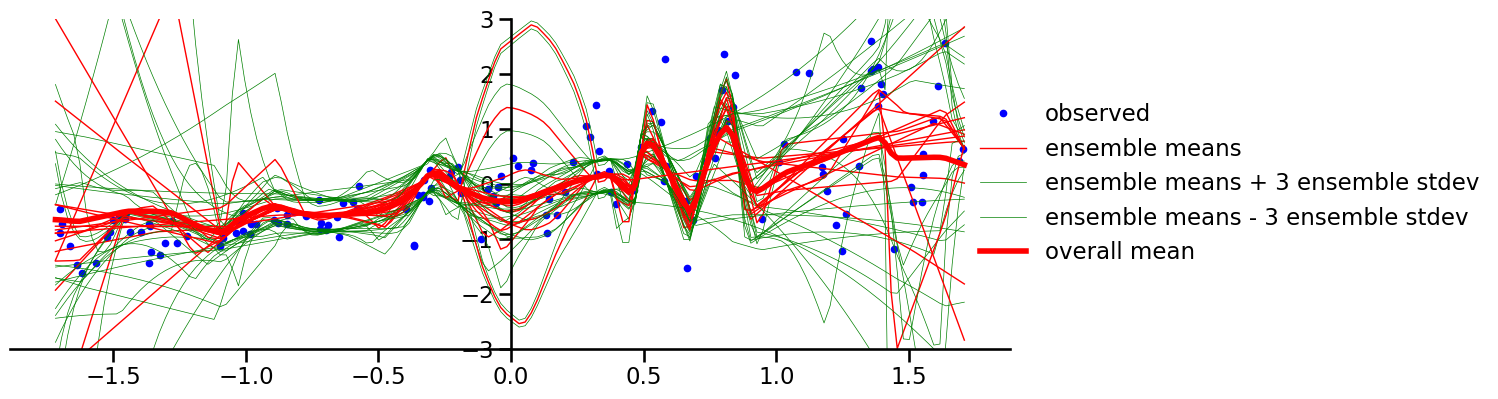

In [9]:
model = FunctionalParticleOptimization(x[:batch_size], 20, net_fn, n_prior_particles=80)
opt = optax.flatten(optax.adam(1e-3))
keys = hk.PRNGSequence(jax.random.PRNGKey(42))

@jax.jit
def update(x, y, params, key, opt_state):
    grads = model.update_step(params, key, x, y)
    updates, new_opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

opt_state = opt.init(model.params)

for step in range(20000):
    model.params, opt_state = update(*next(data), model.params, next(keys), opt_state)
yhats_fpovi = model.predict(x_tst)
plot(x, y, x_tst, yhats_fpovi)
plt.ylim(-3, 3)

The approximate posterior appears to be underfitting in the $x\in (1,2)$ region. The following experiment with point estimation suggests this may be due to the limited capacity of the NN architecture:

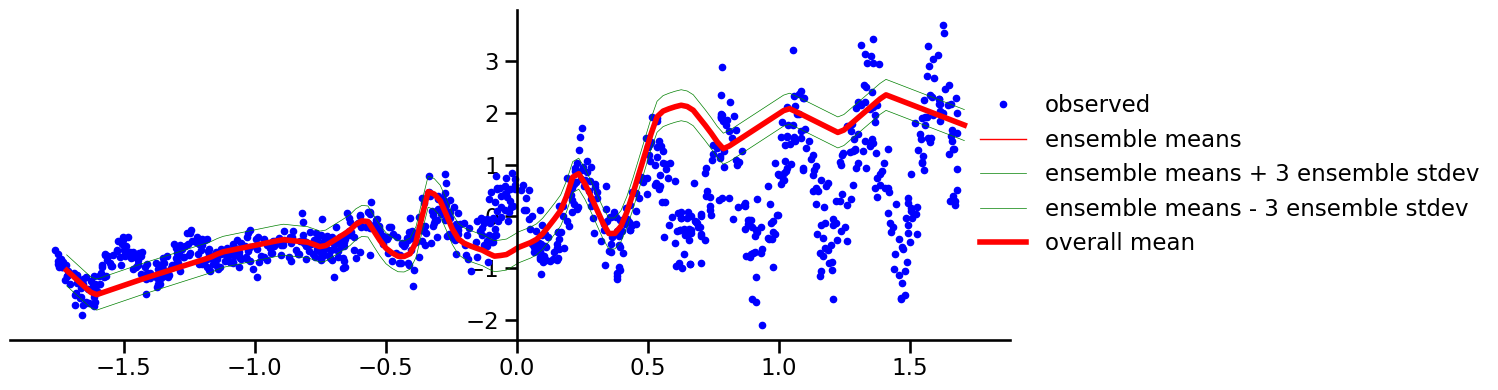

In [10]:
yl, xl = load_dataset(x_range, b0, w0, n=1000)[:2]
large_data = iter(dataset(xl, yl, batch_size))

model = FunctionalParticleOptimization(
    xl[:batch_size], 1,
    functools.partial(utils.net, n_layers=2, n_hidden=100, sd_min=0.1, sd_max=0.1))
def vacuous_prior(inp):
    class A:
        def log_prob(self, inp):
            return jax.numpy.zeros((inp.shape[0],))
    return A()
model._prior = vacuous_prior
opt = optax.flatten(optax.adam(0.004))
keys = hk.PRNGSequence(jax.random.PRNGKey(42))

@jax.jit
def update(x, y, params, key, opt_state):
    grads = model.update_step(params, key, x, y)
    updates, new_opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

opt_state = opt.init(model.params)

for step in range(10000):
    model.params, opt_state = update(*next(large_data), model.params, next(keys), opt_state)
yhats_fpovi = model.predict(x_tst)
plot(xl, yl, x_tst, yhats_fpovi)

In [ ]:
for n_layers in [1, 3, 4]:
    model = FunctionalParticleOptimization(x[:batch_size], 20, functools.partial(utils.net, n_layers=n_layers), n_prior_particles=80)
    opt = optax.flatten(optax.adam(1e-3))
    keys = hk.PRNGSequence(jax.random.PRNGKey(42))
    opt_state = opt.init(model.params)

    for step in range(20000):
        model.params, opt_state = update(*next(data), model.params, next(keys), opt_state)
    yhats_fpovi = model.predict(x_tst)
    plot(x, y, x_tst, yhats_fpovi)
    plt.ylim(-3, 3)
    plt.title(f'n_layers={n_layers}')